In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pickle
from src.utils import get_best_t
from src.utils import get_theory_curves
from utils import get_full_theory_curves, get_best_params

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : 14,
    'style'  : 'normal'}
matplotlib.rc('font', **font)

In [4]:
T_values = np.arange(100, 301, 10)
v0_values = np.arange(0.1, 15, 0.1)
print(v0_values)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8
  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2
  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6
  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.
  7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4
  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8
  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2
 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6
 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.
 14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9]


In [5]:
# Get theoretical positions and depths of log-derivative minima
# across a grid of loop periods T and effective fragment lengths v0

theory_xmins, theory_ymins, s_grid, v0_values = get_theory_curves(T_values, v0_values)

In [6]:
# helper functions

def load_logder_pair(y_name, x_name):
    """Load (mids, slope) from pickle files."""
    with open(f"{data_dir}/{y_name}", "rb") as f:
        slope = pickle.load(f)
    with open(f"{data_dir}/{x_name}", "rb") as f:
        mids = pickle.load(f)
    return np.asarray(mids), np.asarray(slope)


def find_minimum(mids, slope, window=20):
    """
    Find (x, y) of the local minimum within the first `window` points.
    mids is assumed to be 1D, slope is d log P / d log s.
    """
    # use mids[1:] in plotting, but minima are taken from slope[0:window]
    y_min = np.min(slope[:window])
    x_min = mids[1 + np.argmin(slope[:window])]
    return x_min, y_min


def theory_logder(s, T_kb, v0_kb, smooth_sigma=0.1):
    """
    Compute theoretical log-derivative for given T, v0 at separations s (kb).
    Uses Eq. (3) with optional Gaussian smoothing.
    """
    gamma = 2.0 * s / (3.0 * v0_kb)
    y = (
        3.0 * s * gamma * (gamma + 2.0) / (T_kb * 2.0 * (gamma + 1.0) ** 2)
        - 3.0 * gamma / (2.0 * (gamma + 1.0))
    )
    if smooth_sigma is not None and smooth_sigma > 0:
        y = gaussian_filter1d(y, smooth_sigma)
    return y

In [7]:
s_grid, y_array, T_values, v0_values = get_full_theory_curves(T_values, v0_values, s_min=1, s_max=50)

WT:
100.0
1.6
dTAG-20nM:
180.0
1.6
dTAG-45nM:
220.0
1.5000000000000002
Wild type
y-minimum =  -1.0793835516193144
x-minimum =  11.958260743101398
Inferred T  =  100.0
Inferred v0 =  1.6
MSE         =  0.00011199302259102609

RAD21, 20 nM degron
y-minimum =  -1.1839419480015823
x-minimum =  15.968719422671311
Inferred T  =  160.0
Inferred v0 =  1.3000000000000003
MSE         =  3.5949933896230745e-05

RAD21, 45 nM degron
y-minimum =  -1.2097928183001616
x-minimum =  20.445048300260872
Inferred T  =  220.0
Inferred v0 =  1.6
MSE         =  2.753181339365244e-05



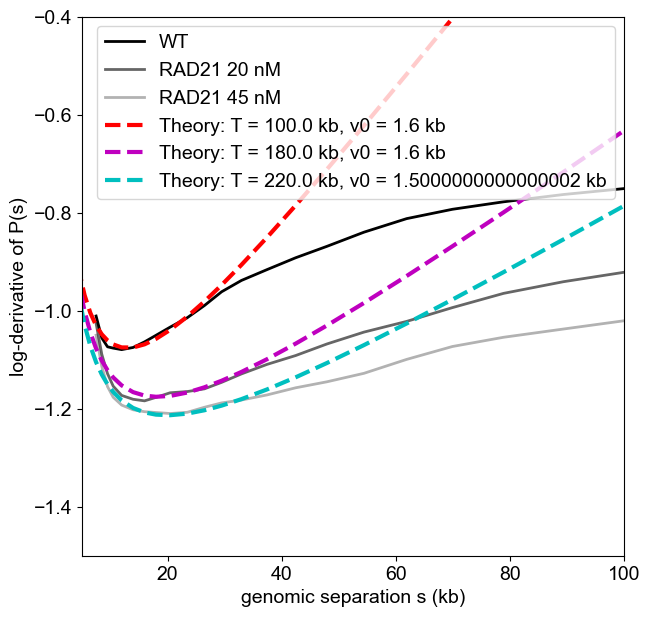

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))

#data_dir = "../data/data_fig4"
data_dir = "logders_fig4"


# --- Load experimental curves ---

mids_wt, slope_wt = load_logder_pair(
    "full_logder_y_shah_untagged_untreated_merge-rep1-2.pickle",
    "full_logder_x_shah_untagged_untreated_merge-rep1-2.pickle",
)

mids_20, slope_20 = load_logder_pair(
    "full_logder_y_shah_RAD21-FKBP_dTAG-20nM_rep1_RSHIC41.pickle",
    "full_logder_x_shah_RAD21-FKBP_dTAG-20nM_rep1_RSHIC41.pickle",
)

mids_45, slope_45 = load_logder_pair(
    "full_logder_y_shah_RAD21-FKBP_dTAG-45nM_rep2_RSHIC42.pickle",
    "full_logder_x_shah_RAD21-FKBP_dTAG-45nM_rep2_RSHIC42.pickle",
)

# --- Get best parameters from fitting the curve around the dip ---

T_opt, v0_opt = get_best_params(mids_wt, slope_wt, s_grid, y_array, \
                                T_values, v0_values, sfit_min=8, sfit_max=30)
print("WT:")
print(T_opt)
print(v0_opt)

T_opt_1, v0_opt_1 = get_best_params(mids_20, slope_20, s_grid, y_array, \
                                    T_values, v0_values, sfit_min=8, sfit_max=30)

print("dTAG-20nM:")
print(T_opt_1)
print(v0_opt_1)

T_opt_2, v0_opt_2 = get_best_params(mids_45, slope_45, s_grid, y_array, \
                                    T_values, v0_values, sfit_min=8, sfit_max=30)

print("dTAG-45nM:")
print(T_opt_2)
print(v0_opt_2)


# --- Plot experimental curves ---

ax.plot(mids_wt[1:], slope_wt, color="k", linewidth=2, label="WT")
ax.plot(mids_20[1:], slope_20, color="k", alpha=0.6, linewidth=2, label="RAD21 20 nM")
ax.plot(mids_45[1:], slope_45, color="k", alpha=0.3, linewidth=2, label="RAD21 45 nM")

# --- Find minima and infer parameters from the dip ---

for label, mids, slope in [
    ("Wild type", mids_wt, slope_wt),
    ("RAD21, 20 nM degron", mids_20, slope_20),
    ("RAD21, 45 nM degron", mids_45, slope_45),
]:
    print(label)
    x_min, y_min = find_minimum(mids, slope, window=20)
    print("y-minimum = ", y_min)
    print("x-minimum = ", x_min)

    t, v0, err = get_best_t(
        (x_min, y_min),
        theory_xmins=theory_xmins,
        theory_ymins=theory_ymins,
        T_values=T_values,
        v0_values=v0_values,
        x_weight=1e-4,
    )
    print("Inferred T  = ", t)
    print("Inferred v0 = ", v0)
    print("MSE         = ", err)
    print()


# --- Plot theory curves for illustrative T values (fixed v0) ---

v0_theory = 1.5  # kb
for T_kb, v0, color, label in [
    (T_opt, v0_opt, "r", f"Theory: T = {T_opt} kb, v0 = {v0_opt} kb"),
    (T_opt_1, v0_opt_1, "m", f"Theory: T = {T_opt_1} kb, v0 = {v0_opt_1} kb"),
    (T_opt_2, v0_opt_2, "c", f"Theory: T = {T_opt_2} kb, v0 = {v0_opt_2} kb"),
]:
    der = theory_logder(mids_wt[1:], T_kb=T_kb, v0_kb=v0, smooth_sigma=0)
    ax.plot(
        mids_wt[1:],
        der,
        color=color,
        linewidth=3,
        linestyle="--",
        label=label,
    )

# --- Axes & aesthetics ---

ax.set_ylim([-1.5, -0.4])
ax.set_xlim([5, 100])

ax.set_xlabel("genomic separation s (kb)")
ax.set_ylabel("log-derivative of P(s)")

ax.legend()
ax.tick_params(labelsize=14)

plt.show()


WT:
100.0
1.6
NIPBL:
160.0
2.0
Wild type
y-minimum =  -1.0793835516193144
x-minimum =  11.958260743101398
Inferred T  =  100.0
Inferred v0 =  1.6
MSE         =  0.00011199302259102609

NIPBL
y-minimum =  -1.123081696527556
x-minimum =  17.97220075561143
Inferred T  =  150.0
Inferred v0 =  1.9000000000000001
MSE         =  3.068814237696578e-05



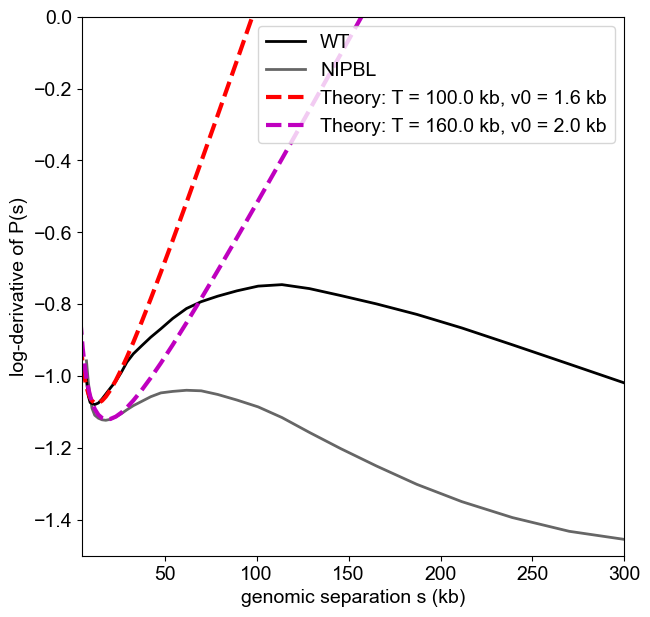

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))

#data_dir = "../data/data_fig4"
data_dir = "logders_fig4"


# --- Load experimental curves ---

mids_wt, slope_wt = load_logder_pair(
    "full_logder_y_shah_untagged_untreated_merge-rep1-2.pickle",
    "full_logder_x_shah_untagged_untreated_merge-rep1-2.pickle",
)

mids_nipbl, slope_nipbl = load_logder_pair(
    "full_logder_y_shah_NIPBL-FKBP_dTAG-24h_merge_rep1-2.pickle",
    "full_logder_x_shah_NIPBL-FKBP_dTAG-24h_merge_rep1-2.pickle",
)


# --- Get best parameters from fitting the curve around the dip ---

T_opt, v0_opt = get_best_params(mids_wt, slope_wt, s_grid, y_array, \
                                T_values, v0_values, sfit_min=8, sfit_max=30)
print("WT:")
print(T_opt)
print(v0_opt)

T_opt_1, v0_opt_1 = get_best_params(mids_nipbl, slope_nipbl, s_grid, y_array, \
                                    T_values, v0_values, sfit_min=8, sfit_max=30)

print("NIPBL:")
print(T_opt_1)
print(v0_opt_1)

# --- Plot experimental curves ---

ax.plot(mids_wt[1:], slope_wt, color="k", linewidth=2, label="WT")
ax.plot(mids_nipbl[1:], slope_nipbl, color="k", alpha=0.6, linewidth=2, label="NIPBL")

# --- Find minima and infer parameters from the dip ---

for label, mids, slope in [
    ("Wild type", mids_wt, slope_wt),
    ("NIPBL", mids_nipbl, slope_nipbl),
]:
    print(label)
    x_min, y_min = find_minimum(mids, slope, window=20)
    print("y-minimum = ", y_min)
    print("x-minimum = ", x_min)

    t, v0, err = get_best_t(
        (x_min, y_min),
        theory_xmins=theory_xmins,
        theory_ymins=theory_ymins,
        T_values=T_values,
        v0_values=v0_values,
        x_weight=1e-4,
    )
    print("Inferred T  = ", t)
    print("Inferred v0 = ", v0)
    print("MSE         = ", err)
    print()


# --- Plot theory curves for illustrative T values (fixed v0) ---

v0_theory = 1.5  # kb
for T_kb, v0, color, label in [
    (T_opt, v0_opt, "r", f"Theory: T = {T_opt} kb, v0 = {v0_opt} kb"),
    (T_opt_1, v0_opt_1, "m", f"Theory: T = {T_opt_1} kb, v0 = {v0_opt_1} kb"),
]:
    der = theory_logder(mids_wt[1:], T_kb=T_kb, v0_kb=v0, smooth_sigma=0)
    ax.plot(
        mids_wt[1:],
        der,
        color=color,
        linewidth=3,
        linestyle="--",
        label=label,
    )

# --- Axes & aesthetics ---

ax.set_ylim([-1.5, 0])
ax.set_xlim([5, 300])

ax.set_xlabel("genomic separation s (kb)")
ax.set_ylabel("log-derivative of P(s)")

ax.legend()
ax.tick_params(labelsize=14)

plt.show()
